In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [2]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

In [3]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'
MODEL_PATH = '/home/dmig/work/dominic_workspace/model/'

## load data

In [4]:
df_merge = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_merge_le.pkl'))
df_meta = pd.read_pickle(os.path.join(DATA_PATH, 'eqp_meta.pkl'))

df_merge.shape, df_meta.shape

((1494418, 334), (1679, 15))

In [8]:
day_cols = [c for c in df_merge.columns if 'days_from_' in c]

In [9]:
day_cols

['days_from_svc_scrb_dt',
 'days_from_fee_chg_dt',
 'days_from_cncl_aply_last_equip_chg_dt',
 'days_from_eqp_acqr_dt',
 'days_from_mktg_dt']

In [11]:
df_merge['diff_mktg_acqr'] = df_merge['days_from_mktg_dt'] - df_merge['days_from_eqp_acqr_dt']

In [ ]:
df_merge

In [31]:
df_merge[df_merge['eqp_nm_rmk']=='#'].shape

(0, 335)

In [42]:
df_meta[df_meta['eqp_pet_nm'].str.contains('노트9')].drop_duplicates(subset=['eqp_nm_rmk']).sort_values('eqp_nm_rmk')

eqp_mdl_cd rep_eqp_mdl_cd     eqp_nm_rmk eqp_pet_nm mfact_nm   mktg_dt  \
145       A0M2           A0M0  갤럭시 노트 9_128G     갤럭시노트9  삼성전자(주)  20180813   
999       A0M7           A0M7  갤럭시 노트 9_512G     갤럭시노트9  삼성전자(주)  20181130   

    smart_phon_yn tablet_yn note_yn disp_size_larg_yn     eqp_siz_ctt  \
145             Y         N       Y                 Y  161.9*76.4*8.8   
999             Y         N       Y                 Y  161.9*76.4*8.8   

    flagship_yn eqp_mdl_size eqp_mdl_ntwk  first_eqp_out_prc  
145           Y        128GB           4G          1094500.0  
999           Y        512GB           4G          1353000.0

In [50]:
df_merge[df_merge['label_tablet_yn']==1]

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
4023      7037118349       2  15.0     19188.0000             0.0   
5570      7279973430       2  32.0      9245.2222             0.0   
5593      7280626156       1  37.0      9000.0000             0.0   
6505      7222587709       2  58.0      8622.0000             0.0   
7461      7273140761       1  39.0      9000.0000             0.0   
...              ...     ...   ...            ...             ...   
1492362   7267815138       1  38.0     24665.7500             0.0   
1493961   7009650227       1  39.0     59900.0000             0.0   
1494013   7269788546       2  51.0     17000.0000             0.0   
1494179   7247118524       2  33.0         0.0000             0.0   
1494256   7279981562       1  35.0     44900.0000             0.0   

         last_eqp_buy_duration  location_weekday_visit_dong  \
4023                       0.0                         16.0   
5570                       0.0                          1.0   
5593                       0.0                         25.0   
6505                     430.0                          1.0   
7461                       0.0                         25.0   
...                        ...                          ...   
1492362                    0.0                         29.0   
1493961                    6.0                          8.0   
1494013                    0.0                         11.0   
1494179                  364.0                          0.0   
1494256                    0.0                         50.0   

         mbr_discount_cnt_convenience_store  app_use_traffic_movie  \
4023                                    0.0                    0.0   
5570                                    0.0                    0.0   
5593                                    0.0                    0.0   
6505                                    0.0                    0.0   
7461                                    0.0                    0.0   
...                                     ...                    ...   
1492362                                 0.0                    0.0   
1493961                                 0.0                    0.0   
1494013                                 0.0                    0.0   
1494179                                 0.0                    0.0   
1494256                                 0.0                    0.0   

         app_use_traffic_driver  ...  label_mfact_nm  label_mktg_dt  \
4023                   0.000000  ...               3       20171116   
5570                   0.000000  ...               3       20171116   
5593                   0.000000  ...               3       20171116   
6505                   0.000000  ...               3       20171116   
7461                   0.000000  ...               3       20171116   
...                         ...  ...             ...            ...   
1492362                0.000000  ...               3       20190529   
1493961                0.000000  ...               0       20181207   
1494013               51.998826  ...               3       20181019   
1494179                0.000000  ...               0       20181207   
1494256                0.000000  ...               3       20190529   

         label_tablet_yn  label_note_yn  label_disp_size_larg_yn  \
4023                   1              0                        0   
5570                   1              0                        0   
5593                   1              0                        0   
6505                   1              0                        0   
7461                   1              0                        0   
...                  ...            ...                      ...   
1492362                1              0                        0   
1493961                1              0                        0   
1494013                1              0                        0   
1494179                1              0         

In [49]:
df_merge[df_merge['label_note_yn']==1]

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
2         7275696370       1  27.0     51046.6667             0.0   
37        7267416193       2  40.0     64011.3333             0.0   
41        1762502600       1  56.0     21495.3333             0.0   
49        7273754458       1  45.0     63593.6667             0.0   
72        1415225109       1  51.0     45232.0000            10.0   
...              ...     ...   ...            ...             ...   
1494412   1110156903       1  52.0     44486.0000             0.0   
1494413   7230885398       2  21.0     33659.0000             0.0   
1494414   7230897898       1  58.0     28032.2500             0.0   
1494415   1524333400       1  41.0     50853.7500             0.0   
1494417   7235227203       2  37.0     47903.5000             0.0   

         last_eqp_buy_duration  location_weekday_visit_dong  \
2                          0.0                         11.0   
37                         0.0                         39.0   
41                         0.0                         10.0   
49                         0.0                         31.0   
72                        42.0                         29.0   
...                        ...                          ...   
1494412                    0.0                         52.0   
1494413                  237.0                          4.0   
1494414                  588.0                         43.0   
1494415                   20.0                         37.0   
1494417                   56.0                         15.0   

         mbr_discount_cnt_convenience_store  app_use_traffic_movie  \
2                                       0.0               0.000000   
37                                      0.0               0.000000   
41                                      0.0               0.000000   
49                                      0.0               0.000000   
72                                      0.0               0.000000   
...                                     ...                    ...   
1494412                                 0.0              92.670169   
1494413                                 0.0               0.000000   
1494414                                 0.0               0.000000   
1494415                                 0.0               0.000000   
1494417                                 0.0               0.000000   

         app_use_traffic_driver  ...  label_mfact_nm  label_mktg_dt  \
2                      0.000000  ...               3       20171103   
37                     0.032843  ...               3       20180813   
41                     0.000000  ...               3       20180813   
49                     0.000000  ...               3       20181130   
72                     0.000000  ...               3       20181130   
...                         ...  ...             ...            ...   
1494412                0.000000  ...               3       20190820   
1494413                0.000000  ...               3       20190820   
1494414                0.000000  ...               3       20190820   
1494415                0.000000  ...               3       20190731   
1494417                0.000000  ...               3       20190820   

         label_tablet_yn  label_note_yn  label_disp_size_larg_yn  \
2                      0              1                        1   
37                     0              1                        1   
41                     0              1                        1   
49                     0              1                        1   
72                     0              1                        1   
...                  ...            ...                      ...   
1494412                0              1                        1   
1494413                0              1                        1   
1494414                0              1                        1   
1494415                0              1         

In [ ]:
df_mer

In [41]:
for ym in df_merge.ym.unique():
    print('='*50)
    print('ym: ', ym)
    total_cnt = df_merge[df_merge['ym']==ym].shape[0]
    print('cnt: ', total_cnt)
    display(df_merge[df_merge['ym']==ym]['label_mfact_nm'].value_counts().head(3)/total_cnt)
    display(df_merge[df_merge['ym']==ym]['label_eqp_pet_nm'].value_counts().head(10)/total_cnt)

ym:  201902
cnt:  239118


3    0.805711
0    0.119937
1    0.066423
Name: label_mfact_nm, dtype: float64

갤럭시S10              0.206459
갤럭시S10+             0.148291
갤럭시노트9              0.089470
갤럭시S8               0.062074
갤럭시S10E             0.053380
아이폰XS               0.049628
갤럭시 WIDE3           0.046274
갤럭시A6               0.038726
갤럭시A9 PRO (2018)    0.036651
갤럭시S9               0.028802
Name: label_eqp_pet_nm, dtype: float64

ym:  201903
cnt:  209756


3    0.782881
0    0.132278
1    0.079821
Name: label_mfact_nm, dtype: float64

갤럭시S10 5G           0.237285
갤럭시S10              0.082682
갤럭시S10E             0.073991
갤럭시 WIDE3           0.059641
갤럭시노트9              0.058082
갤럭시S10+             0.057214
아이폰XS               0.054959
갤럭시S8               0.054554
갤럭시A9 PRO (2018)    0.035660
아이폰XR               0.032180
Name: label_eqp_pet_nm, dtype: float64

ym:  201904
cnt:  240442


3    0.703130
1    0.172137
0    0.118232
Name: label_mfact_nm, dtype: float64

갤럭시S10 5G           0.364803
V50                 0.101600
아이폰XS               0.048003
갤럭시S10E             0.045583
갤럭시 WIDE3           0.035971
아이폰XR               0.033468
갤럭시A30              0.032257
갤럭시S10              0.030456
갤럭시A9 PRO (2018)    0.029321
갤럭시S8               0.028772
Name: label_eqp_pet_nm, dtype: float64

ym:  201905
cnt:  212872


3    0.738312
1    0.131370
0    0.126997
Name: label_mfact_nm, dtype: float64

갤럭시S10 5G           0.439062
갤럭시 WIDE4           0.087593
V50                 0.074993
아이폰XR               0.046465
아이폰XS               0.044614
갤럭시S10E             0.044022
갤럭시A9 PRO (2018)    0.024108
갤럭시A30              0.022615
갤럭시S10              0.015338
갤럭시노트9              0.015075
Name: label_eqp_pet_nm, dtype: float64

ym:  201906
cnt:  255229


3    0.765074
1    0.125111
0    0.107300
Name: label_mfact_nm, dtype: float64

갤럭시S10 5G           0.480122
V50                 0.071144
갤럭시 WIDE4           0.069957
갤럭시노트9              0.046112
아이폰XR               0.044999
아이폰XS               0.039568
갤럭시A50              0.027125
갤럭시S10E             0.026396
갤럭시A30              0.014708
갤럭시A9 PRO (2018)    0.014614
Name: label_eqp_pet_nm, dtype: float64

ym:  201907
cnt:  337001


3    0.853273
0    0.073706
1    0.070851
Name: label_mfact_nm, dtype: float64

갤럭시노트10      0.526197
갤럭시S10 5G    0.126703
갤럭시 WIDE4    0.056139
아이폰XR        0.031240
V50          0.028326
아이폰XS        0.025356
갤럭시S10E      0.023059
갤럭시A50       0.021944
갤럭시노트9       0.021611
갤럭시A40       0.014493
Name: label_eqp_pet_nm, dtype: float64

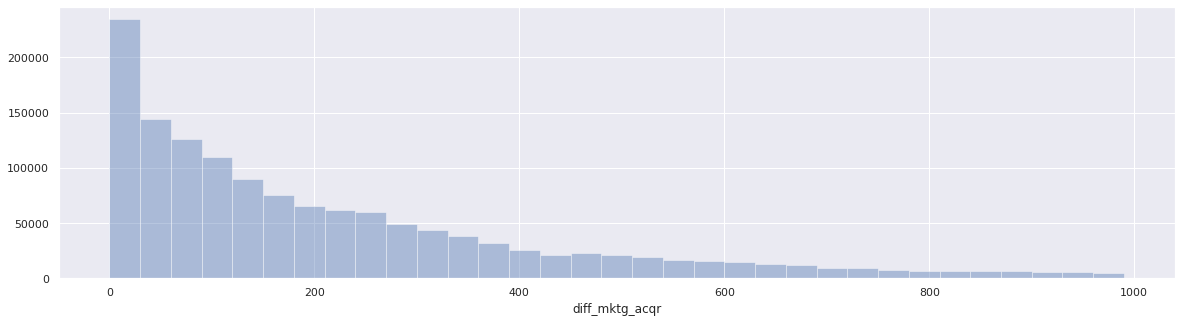

In [17]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df_merge['diff_mktg_acqr'], bins=np.arange(0, 1000, 30), norm_hist=False, kde=False)

In [10]:
df_merge[day_cols].head(50)

days_from_svc_scrb_dt  days_from_fee_chg_dt  \
0                    2228                  1501   
1                    2121                   353   
2                     900                   785   
3                    2115                   594   
4                     852                   852   
5                     651                   285   
6                     578                   578   
7                     911                   724   
8                     690                   690   
9                    2092                  1203   
10                    914                   260   
11                   2091                   407   
12                   2091                   390   
13                   2080                  1953   
14                    816                   816   
15                    921                   326   
16                    708                   708   
17                    816                   816   
18                    928                   928   
19                   2077                  2077   
20                    660                   660   
21                    802                   802   
22                   2147                  1115   
23                    543                   543   
24                    954                   954   
25                   9504                   534   
26                    637                   418   
27                    947                   947   
28                    900                   900   
29                   2135                   598   
30                   2403                  1430   
31                   2358                  1565   
32                   1283                   966   
33                   7591                  2091   
34                    650                   650   
35                   7644                   914   
36                   7105                  1730   
37                   1227                  1227   
38                   5371                   986   
39                   6916                  1110   
40                   2382                   877   
41                   7687                  1589   
42                   7270                  1567   
43                   2375                  1402   
44                   1162                  1023   
45                   8136                  1484   
46                   1139                   298   
47                   1271                  1271   
48                   4405                  1110   
49                    975                   975   

    days_from_cncl_aply_last_equip_chg_dt  days_from_eqp_acqr_dt  \
0                                    1501                   1501   
1                                     825                    825   
2                                    -343                    900   
3                                     691                    691   
4                                    -343                    852   
5                                    -343                    651   
6                                    -343                    578   
7                                    -343                    911   
8                                    -343                    690   
9                                    1203                   1203   
10                                   -343                    914   
11                                   1005                   1005   
12                                   1040                   1040   
13                                   -343                   2080   
14                                   -343                    816   
15                                   -343                    384   
16                                   -343                    390   
17                                   -343                    816   
18                                   -343                    928   
19                                   -343 

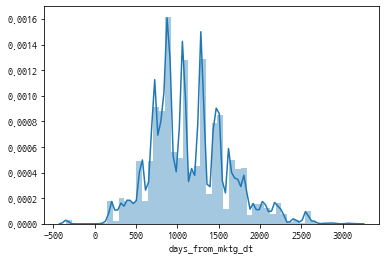

In [5]:
sns.distplot(df_merge['days_from_mktg_dt'])

In [4]:
df_merge['label_price_range'] = df_merge['label_out_prc'].apply(lambda x: 1600000 if x > 1600000 else x)
df_merge['label_price_range'] = pd.cut(df_merge['label_price_range'], bins=np.arange(0,1600001, 400000), labels=np.arange(0,4))

In [5]:
with open(os.path.join(DATA_PATH, 'eqp_le_dict.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

In [6]:
ym_dict = {
    '201907': {'trn': ['201904', '201905'], 'val': '201906', 'tst': '201907'},
    '201905': {'trn': ['201902', '201903'], 'val': '201904', 'tst': '201905'},
    '201903': {'trn': ['201906', '201907'], 'val': '201902', 'tst': '201903'}
}

In [7]:
# feature
idx_col = 'svc_mgmt_num'
target_col = 'label_mfact_nm'
label_cols = [c for c in df_merge.columns if 'label_' in c]
# real_avg_arpu 값 이상함, 제거
feature_cols = [c for c in df_merge.columns if c not in [idx_col, 'ym', 'next_ym', 'real_avg_arpu', 'real_arpu_bf_m3'] + label_cols ]

## modeling

In [88]:
def custom_metrics(predictions, truth):
    predictions = predictions.reshape(4,-1)
    pred_labels = predictions.argmax(axis=0)
    truth = truth.get_label()
    
    acc = accuracy_score(truth, pred_labels)
#     f1 = f1_score(truth, pred_labels, average='weighted')

    return ('accuracy', acc, True) 

In [93]:
# parameters
lgb_params = {
    'objective': 'multiclass',
    'num_class': df_merge[target_col].nunique(),
#     'metric': 'multi_error',
    'boosting_type': 'gbdt',
    'class_weight': 'balanced',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_threads': 60,
}

In [94]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    feval=custom_metrics,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [95]:
clf_dict = {}

In [96]:
for ym, dataset in ym_dict.items():
    print('trn: ', dataset['trn'])
    print('val: ', dataset['val'])
    print('tst: ', dataset['tst'])
    
    # split data
    df_trn = df_merge[df_merge['ym'].isin(dataset['trn'])]
    df_val = df_merge[df_merge['ym']==dataset['val']]
    df_tst = df_merge[df_merge['ym']==dataset['tst']]

    # input
    lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[target_col], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val[feature_cols], df_val[target_col], feature_name=feature_cols)
    
    # train
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])
    
    clf_dict[dataset['tst']] = clf
    
    # test
#     a = evaluate(df_tst[feature_cols], df_tst[target_col], clf, clf_name='lgb' )
    print('')

trn:  ['201904', '201905']
val:  201906
tst:  201907
Training until validation scores don't improve for 100 rounds.
[50]	training's multi_logloss: 0.556693	training's accuracy: 0.784247	valid_1's multi_logloss: 0.513054	valid_1's accuracy: 0.802609
[100]	training's multi_logloss: 0.529254	training's accuracy: 0.789788	valid_1's multi_logloss: 0.496405	valid_1's accuracy: 0.803612
[150]	training's multi_logloss: 0.516421	training's accuracy: 0.793642	valid_1's multi_logloss: 0.491845	valid_1's accuracy: 0.804223
[200]	training's multi_logloss: 0.508055	training's accuracy: 0.796267	valid_1's multi_logloss: 0.490151	valid_1's accuracy: 0.804427
[250]	training's multi_logloss: 0.502085	training's accuracy: 0.798321	valid_1's multi_logloss: 0.488893	valid_1's accuracy: 0.804611
[300]	training's multi_logloss: 0.49716	training's accuracy: 0.799863	valid_1's multi_logloss: 0.488038	valid_1's accuracy: 0.804838
[350]	training's multi_logloss: 0.492823	training's accuracy: 0.801411	valid_1's m

In [97]:
clf_dict

{'201907': <lightgbm.basic.Booster at 0x7fda245d0d30>,
 '201905': <lightgbm.basic.Booster at 0x7fda244e6ba8>,
 '201903': <lightgbm.basic.Booster at 0x7fda24594b70>}

In [98]:
df_dict = {
    '201907': df_merge[df_merge.ym=='201907'],
    '201905': df_merge[df_merge.ym=='201905'],
    '201903': df_merge[df_merge.ym=='201903']
}

In [99]:
for ym, df in df_dict.items():
    df['pred'] = clf_dict[ym].predict(df[feature_cols]).argmax(axis=1)

In [100]:
def make_multi_confusion_matrix(df):
    
    df_cf = pd.DataFrame(
        confusion_matrix(df[target_col], df['pred'], labels=np.arange(df[target_col].nunique())), 
        columns = le_dict[target_col].classes_)
    
    df_cf['Sum'] = df_cf.sum(axis=1)
    df_cf = df_cf.append(df_cf.sum(axis=0), ignore_index=True)
    
    idx_list = list(le_dict[target_col].classes_) + ['Total']
    idx_dict = {}
    for i in np.arange(len(idx_list)):
        idx_dict[i] = idx_list[i]
        
    df_cf.rename(index=idx_dict, inplace=True)
    
    return df_cf

In [101]:
for ym, df in df_dict.items():
    print('='*50)
    print('ym: ', ym)
    print('samsung ratio: ', df[df[target_col]==3].shape[0]/df.shape[0])
    print('accuracy: ', accuracy_score(df[target_col], df['pred']))
    display(make_multi_confusion_matrix(df))

ym:  201907
samsung ratio:  0.8532734324230492
accuracy:  0.8558134842329844


Apple   LG전자   기타    삼성전자     Sum
Apple  16401    176   11    8251   24839
LG전자     793   3493  100   19491   23877
기타        33     27  408     263     731
삼성전자   12647   6673  126  268108  287554
Total  29874  10369  645  296113  337001

ym:  201905
samsung ratio:  0.7383122251869668
accuracy:  0.790968281408546


Apple  LG전자   기타    삼성전자     Sum
Apple  17083    11   46    9894   27034
LG전자     899   250   62   26754   27965
기타        11     0  371     325     707
삼성전자    6238   153  104  150671  157166
Total  24231   414  583  187644  212872

ym:  201903
samsung ratio:  0.782881061805145
accuracy:  0.8257594538416064


Apple  LG전자   기타    삼성전자     Sum
Apple  11716    17    3   16010   27746
LG전자     278   369   39   16057   16743
기타        14     7  303     729    1053
삼성전자    2775   532   87  160820  164214
Total  14783   925  432  193616  209756